# Bayesian Stats Assignment

*Author: Andrés Gordo Ortiz*
**MMRES - BIST-UPF**

## Loading Experimental Data

As requested in the assignment, data is loaded following the provided function, where *z* stands for the redshift of a given galaxy cluster, *h* stands for the experimental measurement of the expansion of a given galaxy cluster, and *herr* represents the uncertainties of the latter value. 

In [21]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')
# Load data
z, h, herr = np.loadtxt('Hz_BC03_all.dat', unpack=True)

## Defining the Model Parametres

The next step ys to define the functions to compute the cosmological model (as it was provided), the likelihood parametres following a Gaussian (Normal) distribution, the uniform Prior assumption and, finnaly, the posterior distribution function to be evaluated at each step during the MCMC Process. All equations were either directly provided or suggested beforehand.

1. The **Model Function** is defined by: $$ H(z)=H_0 \cdot \sqrt{\Omega_m \cdot (1 + z)^3 + (1 - \Omega_m)} $$
2. The **Log-likelihood** function assuming Gaussian errors is defined by: $ \log(D|H_0, \omega_m)= - 0.5 \cdot \sum \left( \frac{h - H_{\text{pred}}}{h_{\text{err}}} \right)^2 $ Where H_pred is the predicted H(z) value previously computed.
3. To begin with, we assume a **uniform prior** over the parameters (H_0) (Hubble constant) and (omega_m) (matter density) with the following constraints: 

    $50 < H_0 < 100 \quad \text{and} \quad 0 < \Omega_m < 1$


    The prior is defined as:

    $$
    p(H_0, \Omega_m) = 
    \begin{cases}
    1 & \text{if } 50 < H_0 < 100 \text{ and } 0 < \Omega_m < 1 \\
    0 & \text{otherwise}
    \end{cases}
    $$

    In log-space, this becomes:

    $$
    \log p(H_0, \Omega_m) =
    \begin{cases}
    0 & \text{if } 50 < H_0 < 100 \text{ and } 0 < \Omega_m < 1 \\
    -\infty & \text{otherwise}
    \end{cases}
    $$
4. The **Log-posterior** function computes the logarithm of the posterior probability, which is the sum of the log-likelihood and the log-prior. This can be calculates because, in Bayesian statistics, the posterior probability combines the likelihood (how well the model fits the data) and the prior (any existing knowledge about the parameters) according to Bayes' theorem: 
    $$ p(H_0, \Omega_m \mid D) \propto p(D \mid H_0, \Omega_m) \cdot p(H_0, \Omega_m)
    $$
Converting to the logarithmic forfaster computation results in: 
    $$
    \log(p(H_0, \Omega_m | D)) = \log(p(D | H_0, \Omega_m)) + \log(p(H_0, \Omega_m))
    $$




In [22]:
# Model function for H(z) as a function of z, H0, and Omega_m
def H_model(z, H0, Omega_m):
    return H0 * np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

# Log-likelihood function assuming Gaussian errors
def log_likelihood(H0, Omega_m):
    H_pred = H_model(z, H0, Omega_m) # Predicted values
    return -0.5 * np.sum(((h - H_pred) / herr) ** 2)

# Define a uniform prior over H0 and Omega_m
def log_prior(H0, Omega_m):
    if 50 < H0 < 100 and 0 < Omega_m < 1:
        return 0.0  # log(1) = 0
    return -np.inf  # log(0) = -inf

# Log posterior (log-likelihood + log-prior)
def log_posterior(H0, Omega_m):
    return log_prior(H0, Omega_m) + log_likelihood(H0, Omega_m)

## Exploring the Data & Parameter Restriction

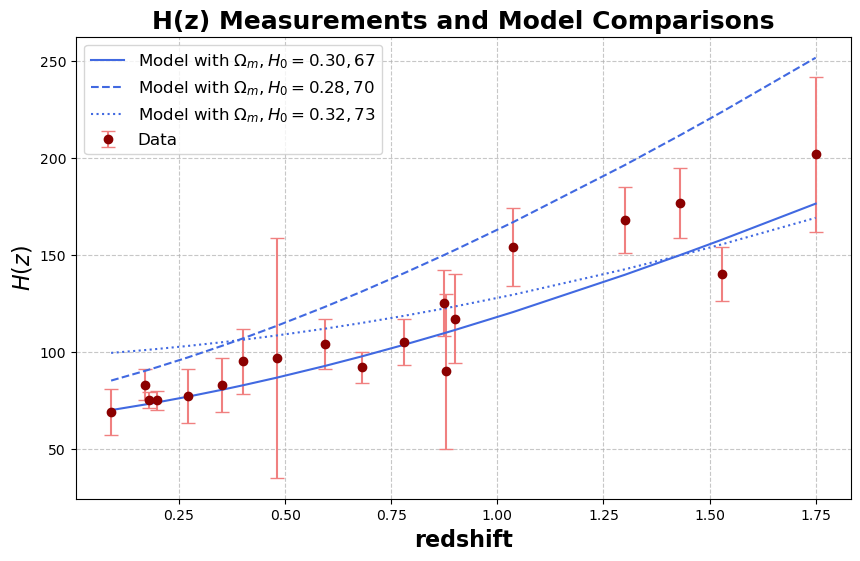

In [23]:
plt.figure(figsize=(10, 6))
plt.xlabel(r'redshift', fontsize=16, fontweight='bold')
plt.ylabel(r'$H(z)$', fontsize=16, fontweight='bold')
plt.errorbar(z, h, yerr=herr, fmt='o', color='darkred', ecolor='lightcoral', capsize=5, label='Data')
plt.plot(z, H_model(z, 67, 0.3), color='royalblue', label=r'Model with $\Omega_m,H_0 = 0.30,67$')
plt.plot(z, H_model(z, 80, 0.45), color='royalblue', linestyle='dashed', label=r'Model with $\Omega_m,H_0 = 0.28,70$')
plt.plot(z, H_model(z, 98, 0.1), color='royalblue', linestyle='dotted', label=r'Model with $\Omega_m,H_0 = 0.32,73$')
plt.legend(fancybox=True, fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('H(z) Measurements and Model Comparisons', fontsize=18, fontweight='bold')
plt.show()

This shows that some sensible values for *H0* might be found between 50 and 100, while the best fitted line of the model is acquired when *omega_m* is around 0.30. However, as the MCMC system will converge, we can ssign different values and let the system run with more cycles.

## Defining and Running the MCMC with Metropolis Algortihm

### MCMC Function

The following function takes a pair of values corresponding to the initial (given by us) parametres for both variables (H0 and omega_m), starts the chain with the flag variable *accepted* equal to 0 and. First, for every step of the chain it computes a new proposed param taken randomly from a normal distribution of mean the former param and standar deviation the *n_steps* parametre. The higher this values is, the wider it will be the average jump of each param in a step. Then the *log_accept_ratio* is calculated as the difference between the formerly explained *log_posterior* of the proposed param and the current param. The bigger the difference (that is, the more likely is our new param to be found in our target distribution) the more likely the proposed param will be selected after randomly (thus, Monte Carlo) challenging it to a random value.

In [24]:
# MCMC sampling using Metropolis-Hastings
def metropolis_hastings(log_posterior, initial_params, n_steps, step_size=1):
    params = np.array(initial_params)
    chain = [params]
    accepted = 0
    log_posterior_old = log_posterior(*params)
    for i in range(n_steps):
        # Propose new parameters
        new_params = params + np.random.normal(scale=step_size, size=2)
        # Calculate the posterior for the new proposed parameters
        log_posterior_new = log_posterior(*new_params)
        # Calculate the likelihood ratio
        log_accept_ratio = log_posterior_new - log_posterior_old
        # Generate a random number for the acceptance decision
        rand = np.log(np.random.rand())

        # Check acceptance conditions based on the likelihood ratio
        if log_accept_ratio >= 0:  # Always accept if the new likelihood is higher
            params = new_params
            log_posterior_old = log_posterior_new
            accepted += 1
        elif rand < log_accept_ratio:  # Accept with probability if likelihood decreases
            params = new_params
            log_posterior_old = log_posterior_new
            accepted += 1
        # If not accepted, append the current params (do not update)
        
        chain.append(params)

    return np.array(chain), accepted / n_steps


## Running MonteCarlo Chains

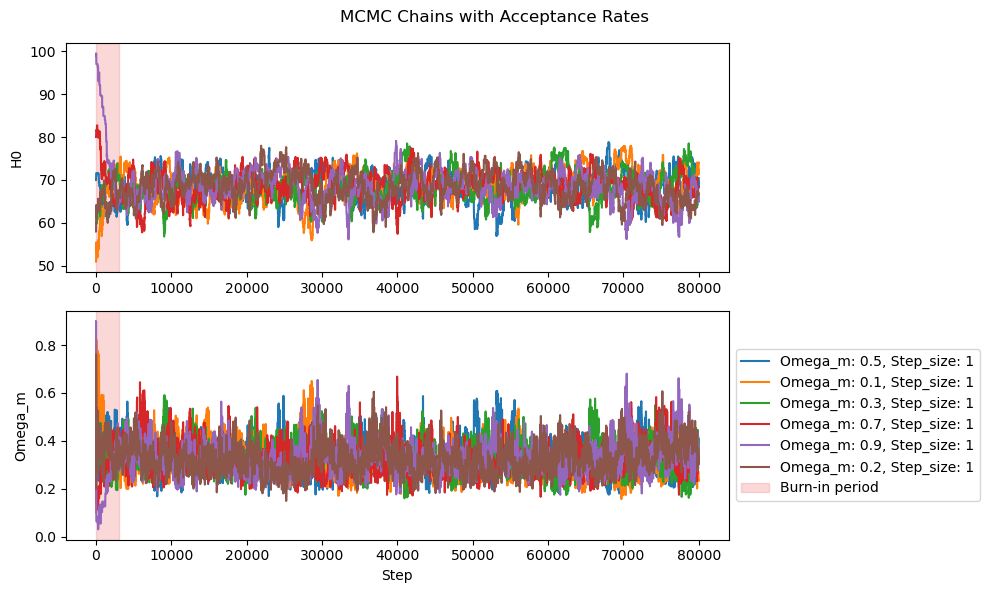

In [25]:
# Initial parameters and MCMC settings
initial_params = [[70, 0.5], [51, 0.1], [60, 0.3], [80, 0.7], [99, 0.9],[58,0.2]]  # Starting point for H0 and Omega_m
n_steps = 80000
step_size = 1
#Flag variable to store final chains
chain_cut = []
chain_raw = []
# Prepare a figure for plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Loop through all combinations of initial parameters and step sizes
for params in initial_params:
    # Run MCMC for the current combination of initial parameters and step size
    chain, acceptance_rate = metropolis_hastings(log_posterior, params, n_steps, step_size)
    chain_raw.append(chain)
    # Burn-in: Discard first 1000 steps and save it into another vriable
    burn_in = 3000
    chain_cut.append(chain[burn_in:])

    # Plot MCMC chain for H0 and Omega_m
    axs[0].plot(chain[:, 0], label=f"H0: {params[0]}, Step_size: {step_size}")
    axs[1].plot(chain[:, 1], label=f"Omega_m: {params[1]}, Step_size: {step_size}")
# Configure the plot
axs[0].set_ylabel("H0")
axs[1].set_ylabel("Omega_m")
axs[1].set_xlabel("Step")
# Highlight the burn-in period
axs[0].axvspan(0, burn_in, color='lightcoral', alpha=0.3, label='Burn-in period')
axs[1].axvspan(0, burn_in, color='lightcoral', alpha=0.3, label='Burn-in period')
plt.suptitle("MCMC Chains with Acceptance Rates")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

We can appreciate how, at the end, all chain converge at around the same values, and the only difference can be foun in the initial burn-in period (shown in red).

In [26]:
from prettytable import PrettyTable

# A table with the acceptance rate of each chain
table = PrettyTable()
table.field_names = ["Chain", "Initial H0", "Initial Omega_m", "Acceptance Rate"]

# Populate the table with acceptance rates
for i, params in enumerate(initial_params):
    table.add_row([i + 1, params[0], params[1], f"{acceptance_rate:.2%}"])

# Print the table
print(table)

+-------+------------+-----------------+-----------------+
| Chain | Initial H0 | Initial Omega_m | Acceptance Rate |
+-------+------------+-----------------+-----------------+
|   1   |     70     |       0.5       |      4.06%      |
|   2   |     51     |       0.1       |      4.06%      |
|   3   |     60     |       0.3       |      4.06%      |
|   4   |     80     |       0.7       |      4.06%      |
|   5   |     99     |       0.9       |      4.06%      |
|   6   |     58     |       0.2       |      4.06%      |
+-------+------------+-----------------+-----------------+


## 2D Density Plots & KDE Gaussian

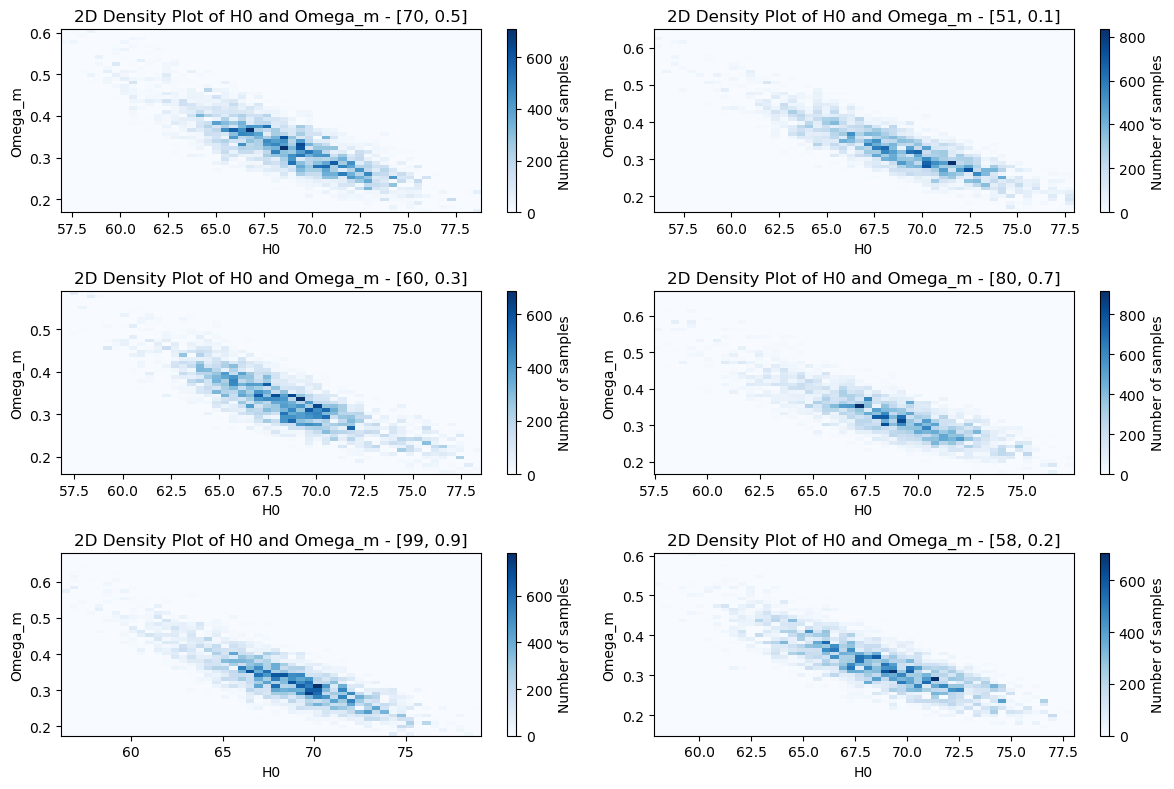

In [27]:
# Set up the figure and axes for subplots
num_chains = len(chain_cut)
cols = 2  # Number of columns for subplots
rows = (num_chains + cols - 1) // cols  # Calculate number of rows needed

fig, axs = plt.subplots(rows, cols, figsize=(12, 8))
axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing

# Loop through each chain and create a density plot
for i, (chain, label) in enumerate(zip(chain_cut, initial_params)):
    # Create a 2D histogram
    heatmap = axs[i].hist2d(chain[:, 0], chain[:, 1], bins=50, cmap='Blues')
    
    # Add colorbar for the current plot
    cbar = plt.colorbar(heatmap[3], ax=axs[i])  # heatmap[3] is the QuadMesh
    cbar.set_label('Number of samples')

    # Set axis labels and title
    axs[i].set_xlabel('H0')
    axs[i].set_ylabel('Omega_m')
    axs[i].set_title(f'2D Density Plot of H0 and Omega_m - {label}')

# Adjust layout for better spacing
plt.tight_layout()



# Show the figure
plt.show()





After removing the burn-in period, the values of the params plotted above represent the sampling landscape of our posterior distribution. We can also generate a gaussian density representation of the dots as shown below.

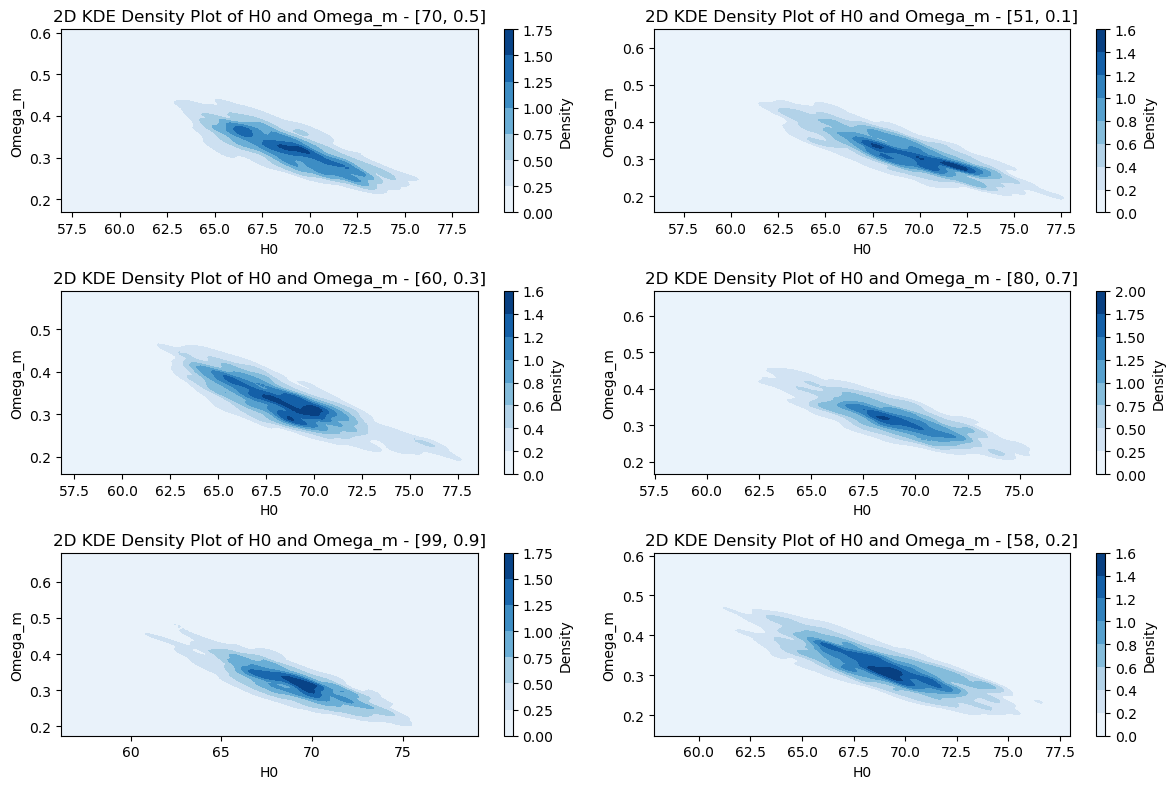

In [28]:

# Set up the figure and axes for subplots
num_chains = len(chain_cut)
cols = 2  # Number of columns for subplots
rows = (num_chains + cols - 1) // cols  # Calculate number of rows needed

fig, axs = plt.subplots(rows, cols, figsize=(12, 8))
axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing

# Loop through each chain and create a KDE density plot
for i, (chain, label) in enumerate(zip(chain_cut, initial_params)):
    # Extract the parameters (H0 and Omega_m) from the chain
    h0_vals = chain[:, 0]
    omega_m_vals = chain[:, 1]

    # Perform kernel density estimation on the chain data
    kde = gaussian_kde([h0_vals, omega_m_vals])
    
    # Define grid points for evaluation of the KDE
    h0_min, h0_max = h0_vals.min(), h0_vals.max()
    omega_m_min, omega_m_max = omega_m_vals.min(), omega_m_vals.max()
    
    # Create grid points for the KDE plot
    h0_grid, omega_m_grid = np.meshgrid(np.linspace(h0_min, h0_max, 100), 
                                        np.linspace(omega_m_min, omega_m_max, 100))
    
    # Evaluate the KDE on the grid
    kde_values = kde([h0_grid.ravel(), omega_m_grid.ravel()]).reshape(h0_grid.shape)
    
    # Plot the density using contour plot
    density_plot = axs[i].contourf(h0_grid, omega_m_grid, kde_values, cmap='Blues')

    # Add colorbar for the current plot
    cbar = plt.colorbar(density_plot, ax=axs[i])
    cbar.set_label('Density')

    # Set axis labels and title
    axs[i].set_xlabel('H0')
    axs[i].set_ylabel('Omega_m')
    axs[i].set_title(f'2D KDE Density Plot of H0 and Omega_m - {label}')

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()


## 1D Histograms (showing Normality)

68% confidence interval for H0: 65.29 to 71.97
68% confidence interval for Omega_m: 0.26 to 0.39


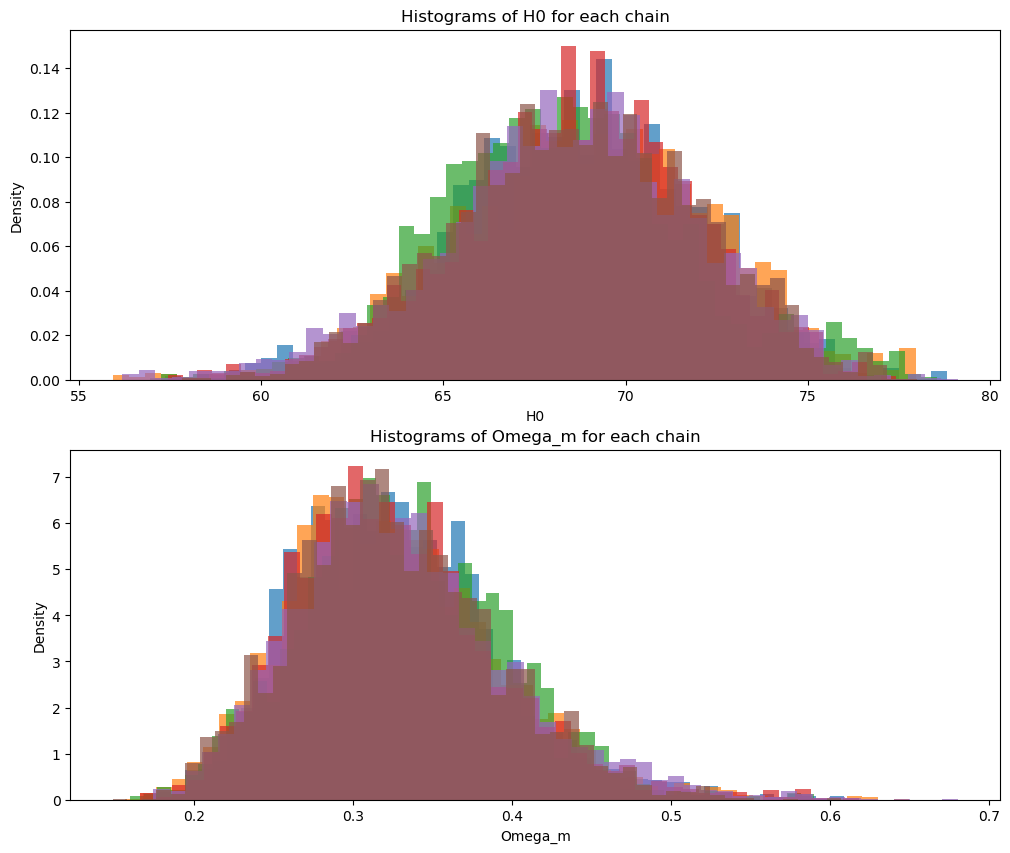

In [29]:
# 1D Histograms for H0 and Omega_m for each chain in chain_cut
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Loop through each chain and plot histograms
for i, chain in enumerate(chain_cut):
    axs[0].hist(chain[:, 0], bins=50, density=True, alpha=0.7, label=f'Chain {i+1}')
    axs[1].hist(chain[:, 1], bins=50, density=True, alpha=0.7, label=f'Chain {i+1}')

# Set labels and titles
axs[0].set_xlabel('H0')
axs[0].set_ylabel('Density')
axs[0].set_title('Histograms of H0 for each chain')
axs[1].set_xlabel('Omega_m')
axs[1].set_ylabel('Density')
axs[1].set_title('Histograms of Omega_m for each chain')

# Add legends
# Concatenate all samples for H0 and Omega_m from each chain
H0_samples = np.concatenate([chain[:, 0] for chain in chain_cut])
Omega_m_samples = np.concatenate([chain[:, 1] for chain in chain_cut])

H0_lower, H0_upper = np.percentile(H0_samples, [16, 84])
Omega_m_lower, Omega_m_upper = np.percentile(Omega_m_samples, [16, 84])

print(f"68% confidence interval for H0: {H0_lower:.2f} to {H0_upper:.2f}")
print(f"68% confidence interval for Omega_m: {Omega_m_lower:.2f} to {Omega_m_upper:.2f}")

Not surprisingly, the sample values follow the normal distribution, as we programmed it before. From this graph we may now obtain the mean and variance of the posterior.

## Convergence Calculation

In [30]:
# Number of chains already stored in chain_raw 
num_chains = len(chain_raw)

param_index = 1

# --- Step 1: Calculate means and variances for each chain ---
means = np.array([np.mean(chain, axis=0)[param_index] for chain in chain_raw])
variances = np.array([np.var(chain, axis=0, ddof=1)[param_index] for chain in chain_raw])

# --- Step 2: Calculate total number of samples (N) and number of chains (M) ---
N = float(chain_raw[0].shape[0])  # Assuming all chains have the same number of samples
M = float(num_chains)

# --- Step 3: Calculate between-chain variance (B) ---
B = (1.0 / (M - 1)) * ((means - means.mean()) ** 2).sum()

# --- Step 4: Calculate within-chain variance (W) ---
W = (1.0 / M) * variances.sum()

# --- Step 5: Compute the potential scale reduction factor (R_hat) ---
if W > 0:  # Prevent division by zero
    R_hat = np.sqrt(((N - 1) / N * W) + (B * (1 + 1 / M) / N))
else:
    R_hat = np.inf  # Or handle the case as needed

# Print the result to monitor the convergence of the chains
print("Potential Scale Reduction Factor (R_hat):", R_hat)
if R_hat < 1.1:
    print("Convergence is good.")
else:
    print("Convergence may not be adequate.")


Potential Scale Reduction Factor (R_hat): 0.06732906582904442
Convergence is good.


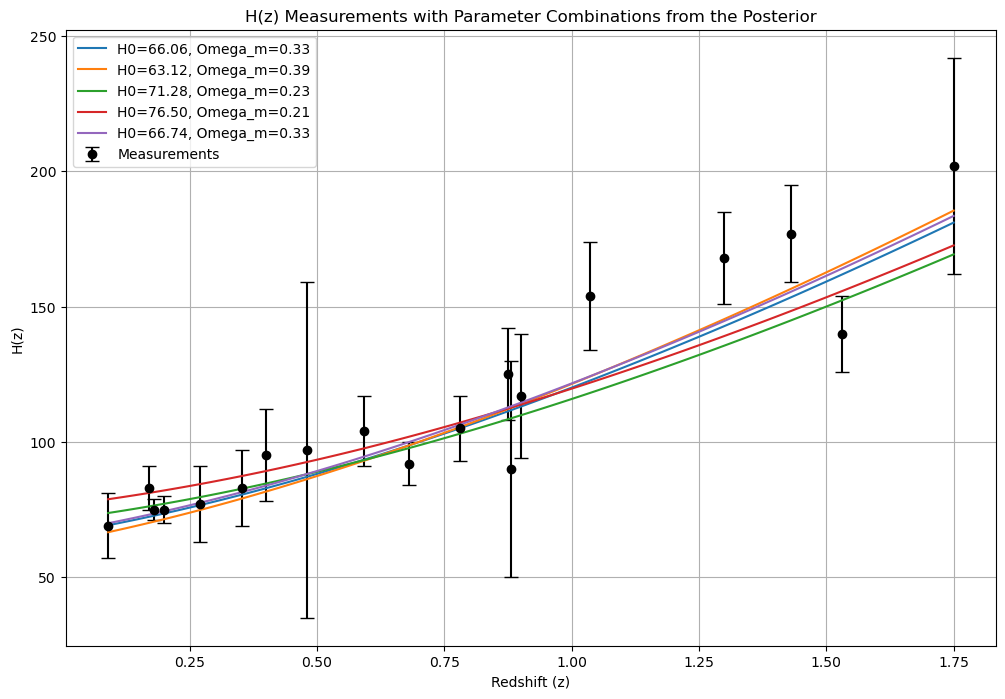

In [31]:
# Draw parameter combinations from the posterior
n_samples = 5  # Number of parameter combinations to plot
indices = np.random.choice(chain.shape[0], size=n_samples, replace=False)
H0_samples = chain[indices, 0]
Omega_m_samples = chain[indices, 1]

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the measurements with error bars
plt.errorbar(z, h, yerr=herr, fmt='o', label='Measurements', color='black', capsize=5)

# Plot H(z) for sampled parameter combinations
z_range = np.linspace(min(z), max(z), 100)
for H0, Omega_m in zip(H0_samples, Omega_m_samples):
    h_plot = H_model(z_range, H0, Omega_m)
    plt.plot(z_range, h_plot, label=f'H0={H0:.2f}, Omega_m={Omega_m:.2f}')

# Add plot details
plt.xlabel('Redshift (z)')
plt.ylabel('H(z)')
plt.title('H(z) Measurements with Parameter Combinations from the Posterior')
plt.legend()
plt.grid()
plt.show()


mparing it with the first plot, this shows values of *H(z)* across *z* obtained using the converged vaues of each chain. These follow the data much better, as it should be, since we are adjusting our prior knowledge to new data.

## Repeating the Report with Known Prior Omega

In [32]:
# Log-prior function with Gaussian prior on Omega_m
def log_prior_gaussian(H0, Omega_m):
    if 50 < H0 < 100:
        H0_prior = 0.0  # log(1) = 0
    else:
        H0_prior = -np.inf  # log(0) = -inf
    Omega_m_prior = norm.logpdf(Omega_m, loc=0.315, scale=0.007) # Gaussian prior for Omega_m with mean 0.315 and standard deviation 0.007
    return H0_prior + Omega_m_prior

# Log posterior with Gaussian prior
def log_posterior_gaussian(H0, Omega_m):
    return log_prior_gaussian(H0, Omega_m) + log_likelihood(H0, Omega_m)

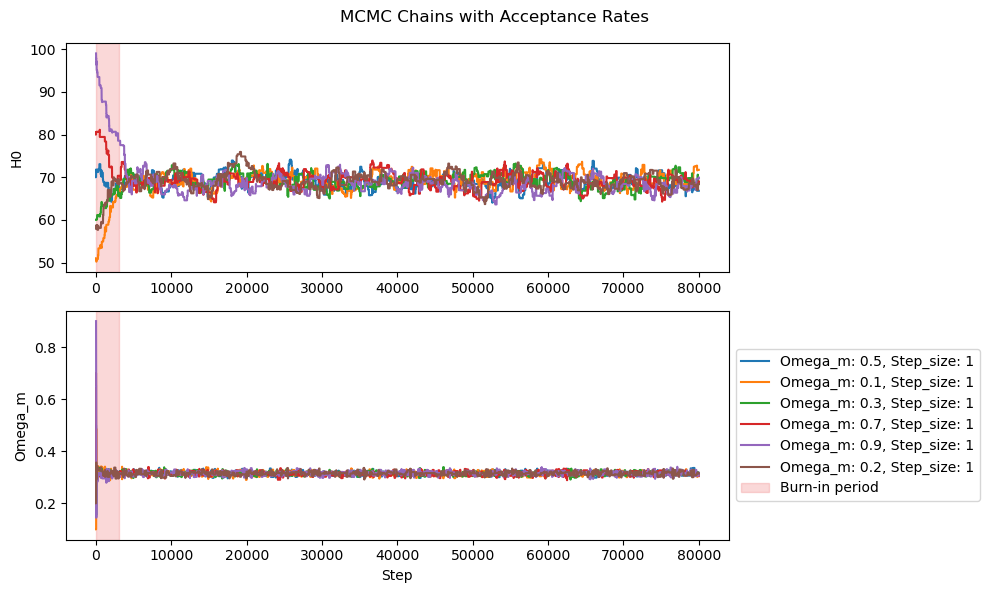

In [33]:
# Initial parameters and MCMC settings
initial_params = [[70, 0.5], [51, 0.1], [60, 0.3], [80, 0.7], [99, 0.9],[58,0.2]]  # Starting point for H0 and Omega_m
n_steps = 80000
step_size = 1
#Flag variable to store final chains
chain_cut = []
chain_raw = []
# Prepare a figure for plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Loop through all combinations of initial parameters and step sizes
for params in initial_params:
    # Run MCMC for the current combination of initial parameters and step size
    chain, acceptance_rate = metropolis_hastings(log_posterior_gaussian, params, n_steps, step_size)
    chain_raw.append(chain)
    # Burn-in: Discard first 1000 steps and save it into another vriable
    burn_in = 3000
    chain_cut.append(chain[burn_in:])

    # Plot MCMC chain for H0 and Omega_m
    axs[0].plot(chain[:, 0], label=f"H0: {params[0]}, Step_size: {step_size}")
    axs[1].plot(chain[:, 1], label=f"Omega_m: {params[1]}, Step_size: {step_size}")
# Configure the plot
axs[0].set_ylabel("H0")
axs[1].set_ylabel("Omega_m")
axs[1].set_xlabel("Step")
# Highlight the burn-in period
axs[0].axvspan(0, burn_in, color='lightcoral', alpha=0.3, label='Burn-in period')
axs[1].axvspan(0, burn_in, color='lightcoral', alpha=0.3, label='Burn-in period')
plt.suptitle("MCMC Chains with Acceptance Rates")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [34]:
from prettytable import PrettyTable

# A table with the acceptance rate of each chain
table = PrettyTable()
table.field_names = ["Chain", "Initial H0", "Initial Omega_m", "Acceptance Rate"]

# Populate the table with acceptance rates
for i, params in enumerate(initial_params):
    table.add_row([i + 1, params[0], params[1], f"{acceptance_rate:.2%}"])

# Print the table
print(table)


+-------+------------+-----------------+-----------------+
| Chain | Initial H0 | Initial Omega_m | Acceptance Rate |
+-------+------------+-----------------+-----------------+
|   1   |     70     |       0.5       |      0.83%      |
|   2   |     51     |       0.1       |      0.83%      |
|   3   |     60     |       0.3       |      0.83%      |
|   4   |     80     |       0.7       |      0.83%      |
|   5   |     99     |       0.9       |      0.83%      |
|   6   |     58     |       0.2       |      0.83%      |
+-------+------------+-----------------+-----------------+


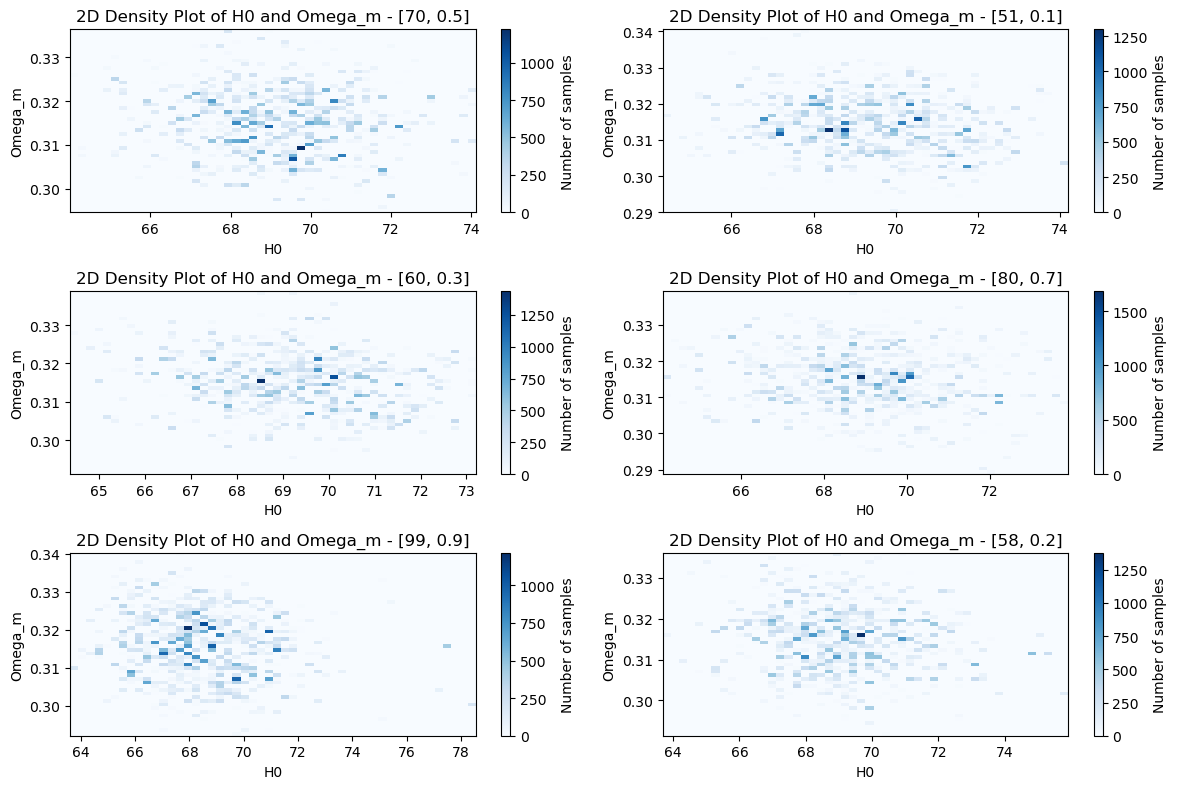

In [35]:
# Set up the figure and axes for subplots
num_chains = len(chain_cut)
cols = 2  # Number of columns for subplots
rows = (num_chains + cols - 1) // cols  # Calculate number of rows needed

fig, axs = plt.subplots(rows, cols, figsize=(12, 8))
axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing

# Loop through each chain and create a density plot
for i, (chain, label) in enumerate(zip(chain_cut, initial_params)):
    # Create a 2D histogram
    heatmap = axs[i].hist2d(chain[:, 0], chain[:, 1], bins=50, cmap='Blues')
    
    # Add colorbar for the current plot
    cbar = plt.colorbar(heatmap[3], ax=axs[i])  # heatmap[3] is the QuadMesh
    cbar.set_label('Number of samples')

    # Set axis labels and title
    axs[i].set_xlabel('H0')
    axs[i].set_ylabel('Omega_m')
    axs[i].set_title(f'2D Density Plot of H0 and Omega_m - {label}')

# Adjust layout for better spacing
plt.tight_layout()

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')  # Hide unused subplots

# Show the figure
plt.show()





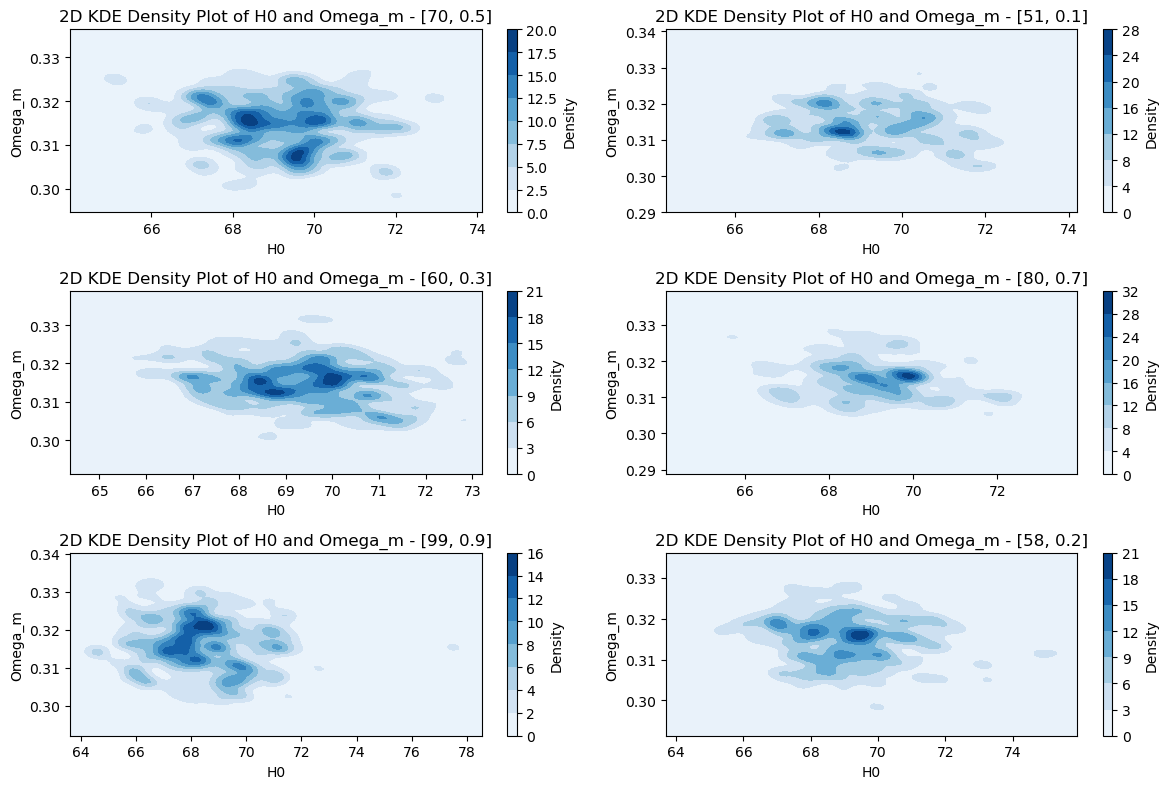

In [36]:

# Set up the figure and axes for subplots
num_chains = len(chain_cut)
cols = 2  # Number of columns for subplots
rows = (num_chains + cols - 1) // cols  # Calculate number of rows needed

fig, axs = plt.subplots(rows, cols, figsize=(12, 8))
axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing

# Loop through each chain and create a KDE density plot
for i, (chain, label) in enumerate(zip(chain_cut, initial_params)):
    # Extract the parameters (H0 and Omega_m) from the chain
    h0_vals = chain[:, 0]
    omega_m_vals = chain[:, 1]

    # Perform kernel density estimation on the chain data
    kde = gaussian_kde([h0_vals, omega_m_vals])
    
    # Define grid points for evaluation of the KDE
    h0_min, h0_max = h0_vals.min(), h0_vals.max()
    omega_m_min, omega_m_max = omega_m_vals.min(), omega_m_vals.max()
    
    # Create grid points for the KDE plot
    h0_grid, omega_m_grid = np.meshgrid(np.linspace(h0_min, h0_max, 100), 
                                        np.linspace(omega_m_min, omega_m_max, 100))
    
    # Evaluate the KDE on the grid
    kde_values = kde([h0_grid.ravel(), omega_m_grid.ravel()]).reshape(h0_grid.shape)
    
    # Plot the density using contour plot
    density_plot = axs[i].contourf(h0_grid, omega_m_grid, kde_values, cmap='Blues')

    # Add colorbar for the current plot
    cbar = plt.colorbar(density_plot, ax=axs[i])
    cbar.set_label('Density')

    # Set axis labels and title
    axs[i].set_xlabel('H0')
    axs[i].set_ylabel('Omega_m')
    axs[i].set_title(f'2D KDE Density Plot of H0 and Omega_m - {label}')

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()


68% confidence interval for H0: 67.30 to 70.82
68% confidence interval for Omega_m: 0.31 to 0.32


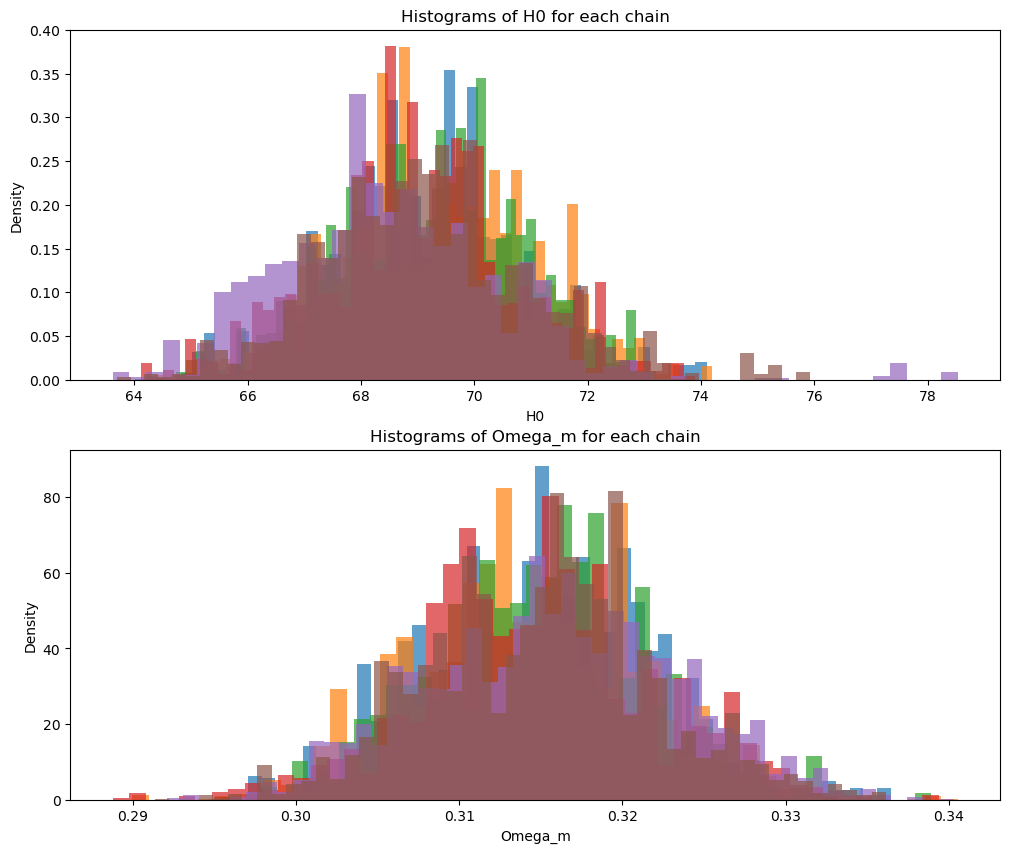

In [37]:
# 1D Histograms for H0 and Omega_m for each chain in chain_cut
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Loop through each chain and plot histograms
for i, chain in enumerate(chain_cut):
    axs[0].hist(chain[:, 0], bins=50, density=True, alpha=0.7, label=f'Chain {i+1}')
    axs[1].hist(chain[:, 1], bins=50, density=True, alpha=0.7, label=f'Chain {i+1}')

# Set labels and titles
axs[0].set_xlabel('H0')
axs[0].set_ylabel('Density')
axs[0].set_title('Histograms of H0 for each chain')
axs[1].set_xlabel('Omega_m')
axs[1].set_ylabel('Density')
axs[1].set_title('Histograms of Omega_m for each chain')

# Add legends
# Concatenate all samples for H0 and Omega_m from each chain
H0_samples = np.concatenate([chain[:, 0] for chain in chain_cut])
Omega_m_samples = np.concatenate([chain[:, 1] for chain in chain_cut])

H0_lower, H0_upper = np.percentile(H0_samples, [16, 84])
Omega_m_lower, Omega_m_upper = np.percentile(Omega_m_samples, [16, 84])

print(f"68% confidence interval for H0: {H0_lower:.2f} to {H0_upper:.2f}")
print(f"68% confidence interval for Omega_m: {Omega_m_lower:.2f} to {Omega_m_upper:.2f}")

As it can be seen above the plot, the confidence interval of both params when we know its prior value confidently is significantly lower (less dispersed sampling) than when the prior is more open.

In [40]:
# Number of chains already stored in chain_raw 
num_chains = len(chain_raw)

param_index = 1

# --- Step 1: Calculate means and variances for each chain ---
means = np.array([np.mean(chain, axis=0)[param_index] for chain in chain_raw])
variances = np.array([np.var(chain, axis=0, ddof=1)[param_index] for chain in chain_raw])

# --- Step 2: Calculate total number of samples (N) and number of chains (M) ---
N = float(chain_raw[0].shape[0])  # Assuming all chains have the same number of samples
M = float(num_chains)

# --- Step 3: Calculate between-chain variance (B) ---
B = (1.0 / (M - 1)) * ((means - means.mean()) ** 2).sum()

# --- Step 4: Calculate within-chain variance (W) ---
W = (1.0 / M) * variances.sum()

# --- Step 5: Compute the potential scale reduction factor (R_hat) ---
if W > 0:  # Prevent division by zero
    R_hat = np.sqrt(((N - 1) / N * W) + (B * (1 + 1 / M) / N))
else:
    R_hat = np.inf  # Or handle the case as needed

# Print the result to monitor the convergence of the chains
print("Potential Scale Reduction Factor (R_hat):", R_hat)
if R_hat < 1.1:
    print("Convergence is good as it is below 1.1.")
else:
    print("Convergence may not be adequate.")


Potential Scale Reduction Factor (R_hat): 0.008052952442220374
Convergence is good as it is below 1.1.


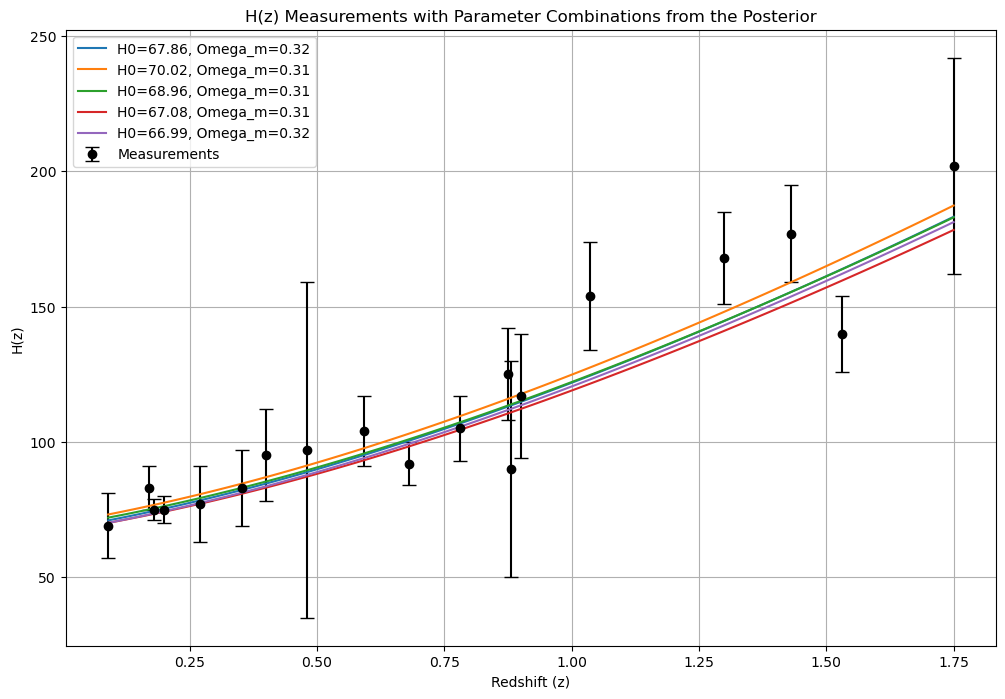

In [39]:
# Draw parameter combinations from the posterior
n_samples = 5  # Number of parameter combinations to plot
indices = np.random.choice(chain.shape[0], size=n_samples, replace=False)
H0_samples = chain[indices, 0]
Omega_m_samples = chain[indices, 1]

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the measurements with error bars
plt.errorbar(z, h, yerr=herr, fmt='o', label='Measurements', color='black', capsize=5)

# Plot H(z) for sampled parameter combinations
z_range = np.linspace(min(z), max(z), 100)
for H0, Omega_m in zip(H0_samples, Omega_m_samples):
    h_plot = H_model(z_range, H0, Omega_m)
    plt.plot(z_range, h_plot, label=f'H0={H0:.2f}, Omega_m={Omega_m:.2f}')

# Add plot details
plt.xlabel('Redshift (z)')
plt.ylabel('H(z)')
plt.title('H(z) Measurements with Parameter Combinations from the Posterior')
plt.legend()
plt.grid()
plt.show()
